<a href="https://colab.research.google.com/github/NastaCom/ML_for_business/blob/main/hw_7_GorokhovaA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Домашнее задание

Практическое задание:
- взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
- сделать обзорный анализ выбранного датасета
- сделать feature engineering
- обучить любой классификатор (какой вам нравится)
- разобраться с SHAP и построить важности признаков для:
    - всего тестового набора данных (summary_plot - дать интерпретацию)
    - для топ 10%
- для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат

https://archive.ics.uci.edu/ml/datasets/Algerian+Forest+Fires+Dataset++

Аннотация : набор данных включает 244 экземпляра, которые перегруппировывают данные двух регионов Алжира.
    
Набор данных включает 244 экземпляра, которые перегруппировывают данные двух регионов Алжира, а именно региона Беджая, расположенного на северо-востоке Алжира, и региона Сиди-Бель-Аббес, расположенного на северо-западе Алжира.

122 экземпляра для каждого региона.

Период с июня 2012 г. по сентябрь 2012
г. Набор данных включает 11 атрибутов и 1 выходной атрибут (класс)
. 244 случая были классифицированы как «пожарные» (138 классов) и «не пожарные» (106 классов). классы.

Информация об атрибутах:

1. Дата: (ДД/ММ/ГГГГ) День, месяц (с июня по сентябрь), год (2012 г.)
Наблюдения за погодными данными
2. Температура: температура в полдень (максимальная температура) в градусах Цельсия: от 22 до 42
3. RH : Относительная влажность в %: от 21 до 90
4. Ws : Скорость ветра в км/ч: от 6 до 29
5. Дождь: общее количество дней в мм: от 0 до 16,8
Компоненты FWI
6. Индекс точного определения влажности топлива (FFMC) из Система FWI: от 28,6 до 92,5
7. Индекс кода влажности Даффа (DMC) из системы FWI: от 1,1 до 65,9
8. Индекс кода засухи (DC) из системы FWI: от 7 до 220,4
9. Индекс начального распространения (ISI) из Система FWI: от 0 до 18,5
10. Индекс индекса застройки (BUI) из системы FWI: от 1,1 до 68
11. Индекс индекса пожарной погоды (FWI): от 0 до 31,1
12. Классы: два класса, а именно «Огонь» и «Не огонь».

In [ ]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import catboost as catb
import shap

from sklearn.inspection import permutation_importance
# load JS visualization code to notebook
shap.initjs()

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

import itertools

import matplotlib.pyplot as plt

%matplotlib inline

import warnings
warnings.simplefilter("ignore")

In [ ]:
df = pd.read_csv('Algerian_forest_fires_dataset_UPDATE.csv', header=1)
df.head(5)

,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes
0,01,06,2012,29,57,18,0,65.7,3.4,7.6,1.3,3.4,0.5,not fire
1,02,06,2012,29,61,13,1.3,64.4,4.1,7.6,1,3.9,0.4,not fire
2,03,06,2012,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire
3,04,06,2012,25,89,13,2.5,28.6,1.3,6.9,0,1.7,0,not fire
4,05,06,2012,27,77,16,0,64.8,3,14.2,1.2,3.9,0.5,not fire


In [ ]:
df.columns

Index(['day', 'month', 'year', 'Temperature', ' RH', ' Ws', 'Rain ', 'FFMC',
       'DMC', 'DC', 'ISI', 'BUI', 'FWI', 'Classes  '],
      dtype='object')

In [ ]:
df = df.rename(columns = {'Classes  ': 'Classes'} )

In [ ]:
df.shape

(246, 14)

In [ ]:
df = df[df['Classes'].notna()]
df

,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes
0,01,06,2012,29,57,18,0,65.7,3.4,7.6,1.3,3.4,0.5,not fire
1,02,06,2012,29,61,13,1.3,64.4,4.1,7.6,1,3.9,0.4,not fire
2,03,06,2012,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire
3,04,06,2012,25,89,13,2.5,28.6,1.3,6.9,0,1.7,0,not fire
4,05,06,2012,27,77,16,0,64.8,3,14.2,1.2,3.9,0.5,not fire
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,26,09,2012,30,65,14,0,85.4,16,44.5,4.5,16.9,6.5,fire
242,27,09,2012,28,87,15,4.4,41.1,6.5,8,0.1,6.2,0,not fire
243,28,09,2012,27,87,29,0.5,45.9,3.5,7.9,0.4,3.4,0.2,not fire
244,29,09,2012,24,54,18,0.1,79.7,4.3,15.2,1.7,5.1,0.7,not fire


In [ ]:
uniqueValues = df['Classes'].unique()
print('уникальные значения в "Classes" ')
print(uniqueValues)

уникальные значения в "Classes" 
['not fire   ' 'fire   ' 'fire' 'fire ' 'not fire' 'not fire ' 'Classes  '
 'not fire     ' 'not fire    ']


In [ ]:
df['Classes'] = df['Classes'].str.replace('not fire   ', 'not fire')
df['Classes'] = df['Classes'].str.replace('not fire ', 'not fire')
df['Classes'] = df['Classes'].str.replace('not fire     ', 'not fire')
df['Classes'] = df['Classes'].str.replace('not fire    ', 'not fire')
df['Classes'] = df['Classes'].str.replace('not fire ', 'not fire')

df['Classes'] = df['Classes'].str.replace('fire   ', 'fire')
df['Classes'] = df['Classes'].str.replace('fire ', 'fire')

df = df[df.Classes != "Classes  "]

In [ ]:
uniqueValues = df['Classes'].unique()
print('уникальные значения в "Classes" ')
print(uniqueValues)

уникальные значения в "Classes" 
['not fire' 'fire']


In [ ]:
from sklearn.preprocessing import LabelEncoder
df['Classes_enc']=LabelEncoder().fit_transform(df[['Classes']])
df

,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes,Classes_enc
0,01,06,2012,29,57,18,0,65.7,3.4,7.6,1.3,3.4,0.5,not fire,1
1,02,06,2012,29,61,13,1.3,64.4,4.1,7.6,1,3.9,0.4,not fire,1
2,03,06,2012,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire,1
3,04,06,2012,25,89,13,2.5,28.6,1.3,6.9,0,1.7,0,not fire,1
4,05,06,2012,27,77,16,0,64.8,3,14.2,1.2,3.9,0.5,not fire,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,26,09,2012,30,65,14,0,85.4,16,44.5,4.5,16.9,6.5,fire,0
242,27,09,2012,28,87,15,4.4,41.1,6.5,8,0.1,6.2,0,not fire,1
243,28,09,2012,27,87,29,0.5,45.9,3.5,7.9,0.4,3.4,0.2,not fire,1
244,29,09,2012,24,54,18,0.1,79.7,4.3,15.2,1.7,5.1,0.7,not fire,1


In [ ]:
df.drop(columns='Classes',axis=1,inplace=True)
df

,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes_enc
0,01,06,2012,29,57,18,0,65.7,3.4,7.6,1.3,3.4,0.5,1
1,02,06,2012,29,61,13,1.3,64.4,4.1,7.6,1,3.9,0.4,1
2,03,06,2012,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,1
3,04,06,2012,25,89,13,2.5,28.6,1.3,6.9,0,1.7,0,1
4,05,06,2012,27,77,16,0,64.8,3,14.2,1.2,3.9,0.5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,26,09,2012,30,65,14,0,85.4,16,44.5,4.5,16.9,6.5,0
242,27,09,2012,28,87,15,4.4,41.1,6.5,8,0.1,6.2,0,1
243,28,09,2012,27,87,29,0.5,45.9,3.5,7.9,0.4,3.4,0.2,1
244,29,09,2012,24,54,18,0.1,79.7,4.3,15.2,1.7,5.1,0.7,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243 entries, 0 to 245
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   day          243 non-null    object
 1   month        243 non-null    object
 2   year         243 non-null    object
 3   Temperature  243 non-null    object
 4    RH          243 non-null    object
 5    Ws          243 non-null    object
 6   Rain         243 non-null    object
 7   FFMC         243 non-null    object
 8   DMC          243 non-null    object
 9   DC           243 non-null    object
 10  ISI          243 non-null    object
 11  BUI          243 non-null    object
 12  FWI          243 non-null    object
 13  Classes_enc  243 non-null    int32 
dtypes: int32(1), object(13)
memory usage: 27.5+ KB


In [ ]:
for column in df:
    if df[column].dtypes == np.object:
        df[column] = df[column].astype(str).astype(float)

df.dtypes

day            float64
month          float64
year           float64
Temperature    float64
 RH            float64
 Ws            float64
Rain           float64
FFMC           float64
DMC            float64
DC             float64
ISI            float64
BUI            float64
FWI            float64
Classes_enc      int32
dtype: object

In [ ]:
df.iloc[:, -1].value_counts(normalize=True)

0    0.563786
1    0.436214
Name: Classes_enc, dtype: float64

In [ ]:
df.columns

Index(['day', 'month', 'year', 'Temperature', ' RH', ' Ws', 'Rain ', 'FFMC',
       'DMC', 'DC', 'ISI', 'BUI', 'FWI', 'Classes_enc'],
      dtype='object')

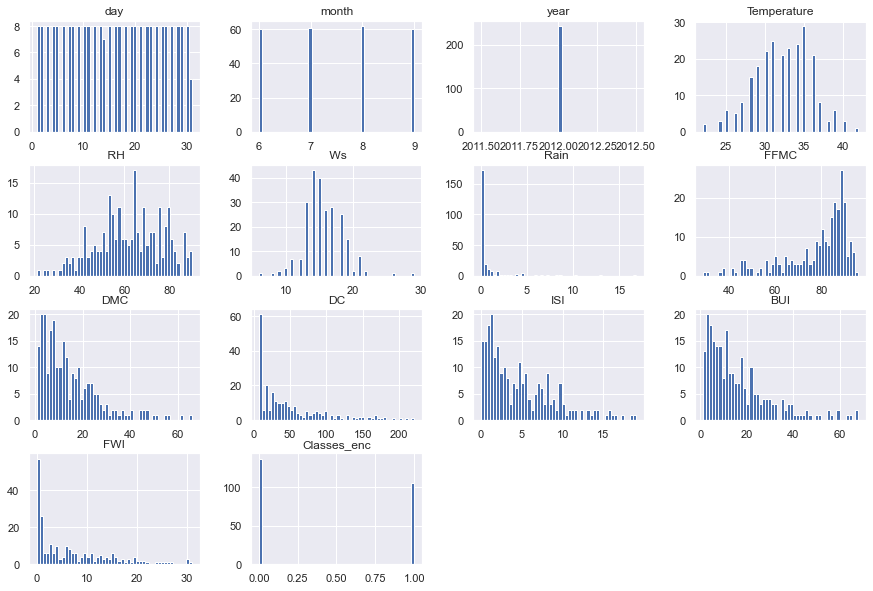

In [ ]:
df.hist(bins=50, figsize=(15,10), ec='w')
plt.show()

In [ ]:
target = 'Classes_enc'
feature = df.columns.drop(target).tolist()

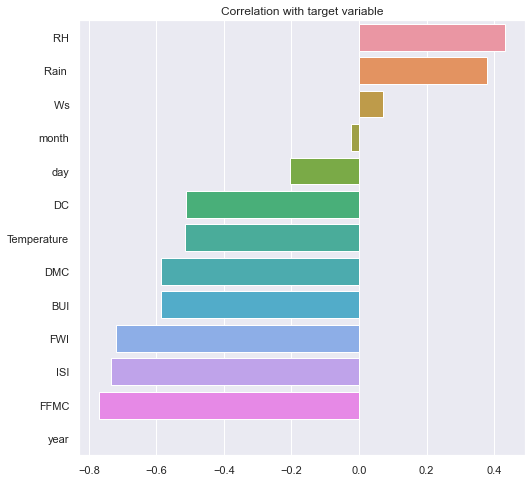

In [ ]:
corr_with_target = df[feature + [target]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(8, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

#### Получается, что относительная влажность имеет большее значение для целевой переменной, чем количество дождей

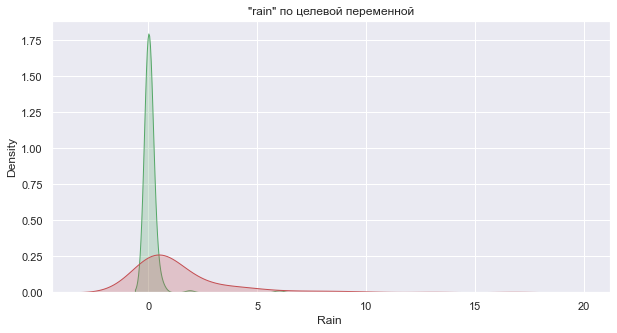

In [ ]:
rain_with_target = df[['Rain ', target]]
rain_s = rain_with_target['Rain ']
rain_target_0 = rain_s[rain_with_target[target] == 0]
rain_target_1 = rain_s[rain_with_target[target] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(rain_target_0, shade=True, label='не пожароопасное состояние', color='g')
sns.kdeplot(rain_target_1, shade=True, label='пожароопасное состояние', color='r')

plt.xlabel('Rain ')
plt.title('"rain" по целевой переменной')
plt.show()

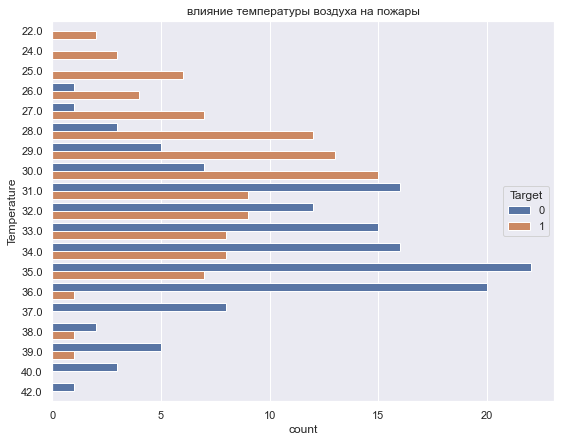

In [ ]:
plt.figure(figsize=(9, 7))

sns.countplot(y="Temperature", hue=target, data=df, orient='h')
plt.title('влияние температуры воздуха на пожары')
plt.legend(title='Target', loc='right')

plt.show()

#### Очень странно, но мы видим, что на целевую переменную влияние значения по температуре незначительное и я бы даже сказала, что ее нет. Я так думаю, потому что судя по графику, при высокой температуре "не пожарное состояние" превышает "пожарное состояние" с пониженой температурой 

### Feature engeneering

Не хватило фантазии. Поэтому скудный Feature engeneering получается...

In [ ]:
df['shower'] = df['Rain '] + df[' Ws']
df['shower'].fillna(0, inplace=True)

In [ ]:
feature += ['shower']

In [ ]:
df.head(3)

,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes_enc,shower
0,1.0,6.0,2012.0,29.0,57.0,18.0,0.0,65.7,3.4,7.6,1.3,3.4,0.5,1,18.0
1,2.0,6.0,2012.0,29.0,61.0,13.0,1.3,64.4,4.1,7.6,1.0,3.9,0.4,1,14.3
2,3.0,6.0,2012.0,26.0,82.0,22.0,13.1,47.1,2.5,7.1,0.3,2.7,0.1,1,35.1


Разбиваем выборку на тренировочную и тестовую части и обучаем модель (в примере - градиентный бустинг)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df[feature], df[target], stratify=df[target], random_state=42)

In [ ]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [ ]:
df.columns

Index(['day', 'month', 'year', 'Temperature', ' RH', ' Ws', 'Rain ', 'FFMC',
       'DMC', 'DC', 'ISI', 'BUI', 'FWI', 'Classes_enc', 'shower'],
      dtype='object')

In [ ]:
columns_ = ['day', 'month', 'year', 'Temperature', ' RH', ' Ws', 'Rain ', 'FFMC', 'DMC', 'DC', 'ISI', 'BUI', 'FWI', 'shower']

In [ ]:
final_transformers = list()

for col in columns_:
    col_transformer = Pipeline([
                ('selector', NumberSelector(key=col))  
                # ('scaler', StandardScaler())
            ])
    final_transformers.append((col, col_transformer))

feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

In [ ]:
pipeline_xgb = Pipeline([
    ('features',feats),
    ('classifier', xgb.XGBClassifier(random_state = 24)),
])

In [ ]:
params_xgb = dict(classifier__n_estimators=[300, 500, 800],
                 classifier__max_depth=[2, 3, 5],
                  classifier__learning_rate=[0.01, 0.1, 0.3])

In [ ]:
def find_parameters(pipe, params):
    
    rs = GridSearchCV(pipe, param_grid=params, scoring='roc_auc', cv=5)  # + кросс-валидация
    rs.fit(X_train, y_train.values.ravel())
    
    print(f"Model: {pipe['classifier']},\n params: {rs.best_params_},\n best_score: {rs.best_score_}\n\n")

In [ ]:
%%time
find_parameters(pipeline_xgb, params_xgb)

[21:14:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:14:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:14:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:14:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[21:14:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:14:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:14:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:14:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[21:14:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:14:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:14:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:14:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[21:15:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:15:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:15:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:15:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[21:15:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:15:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:15:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:15:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[21:15:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model: XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=24, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)

In [ ]:
pipeline_xgb = Pipeline([
    ('features',feats),
    ('classifier', xgb.XGBClassifier(max_depth=2, n_estimators=300, learning_rate=0.01, random_state = 24)),
])

In [ ]:
%%time

#обучим пайплайн на всем тренировочном датасете
def fit_predict_models(pipe):
    pipe.fit(X_train, y_train)
    y_score = pipe.predict_proba(X_test)[:, 1]
    return y_score

y_score_xgb = fit_predict_models(pipeline_xgb)

[21:16:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 514 ms


In [ ]:
def metrics_calculation(y_test, preds, b=1):

    roc_auc = roc_auc_score(y_test, preds)
    precision, recall, thresholds = precision_recall_curve(y_test, preds)
    fscore = (1 + b**2) * (precision * recall) / (b**2 * precision + recall)
    # locate the index of the largest f score
    ix = np.nanargmax(fscore)
    return thresholds[ix], fscore[ix], precision[ix], recall[ix], roc_auc

In [ ]:
metrics_calculation(y_test, y_score_xgb)

(0.9648292, 0.9811320754716981, 1.0, 0.9629629629629629, 0.9956427015250544)

Возьмем абсолютные значения коэффициентов

In [ ]:
xgb_features = pd.DataFrame(pipeline_xgb[1].feature_importances_,
                        X_train.columns,
                        columns=['coefficient'])
xgb_features.head()

,coefficient
day,0.0
month,0.0
year,0.0
Temperature,0.0
RH,0.0


Все значения близки к нулю. Или у всех признаков одинаковое влияние или у меня ошибка...

### Интерпретация результатов с помощью SHAP

In [ ]:
model = xgb.train({"learning_rate": 0.01, 'max_depth': 2, 'n_estimators': 300, 'random_state': 24},
                      xgb.DMatrix(X_train, label=y_train), 100)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

[21:35:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




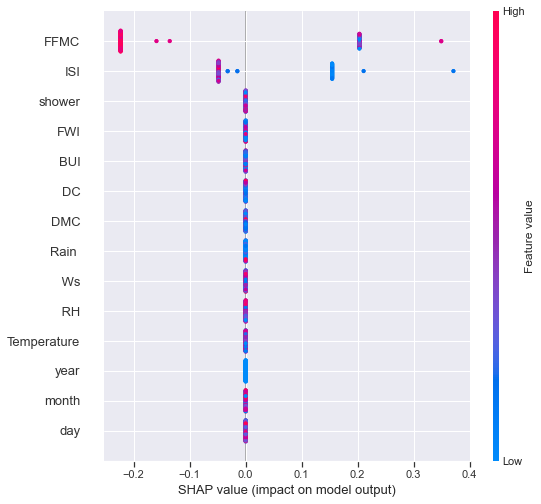

In [ ]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_train)

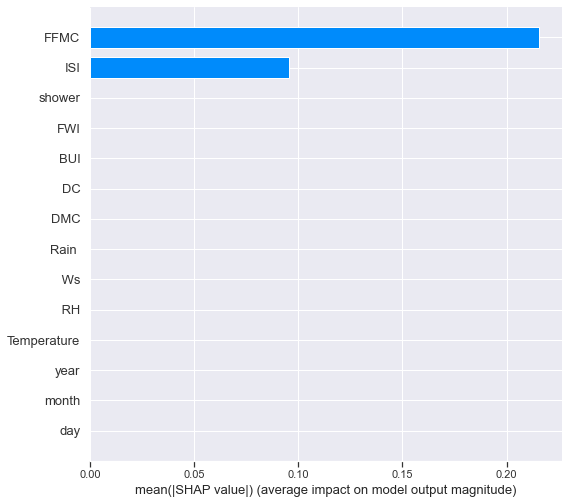

In [ ]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

### По наблюдениям стало понятно, что на выборке из первых 10% предсказаний значительный положительный вклад внесли признаки FFMC и ISI. По версии SHAP остальные признаки из всего набора данных не вносят вклад в прогноз.
### Из этого можно сделать вывод, что от точного определения влажности деревьев в лесу будет зависеть пожароопасность леса (например, если влажность деревьев в лесу будет повышеной, то опасность пожара будет низкой и наоборот). А также важно начальное распространение пожара для более быстрой ликвидации и не распространения на большие территории.